<a href="https://colab.research.google.com/github/Ajjme/STORM_Simulator/blob/main/Organized_STORM_Simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries

In [1]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import random #not used
import matplotlib.pyplot as plt
import pandas as pd

Set up

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


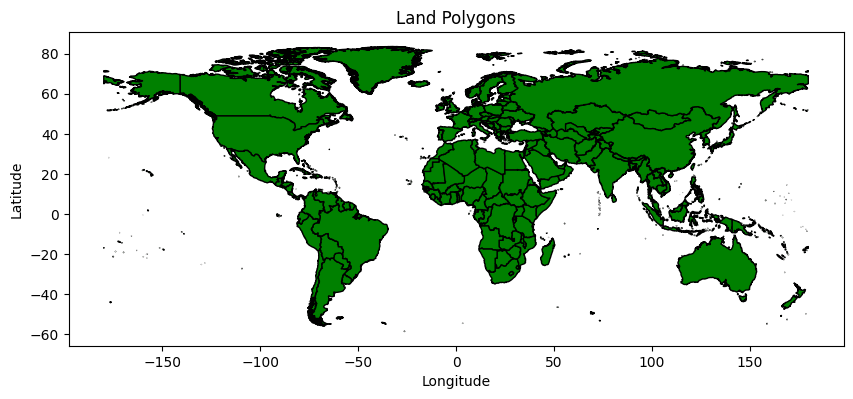

In [3]:
# Use full path to your shapefile
shapefile_path = "/content/drive/MyDrive/Colab_Notebooks/world-administrative-boundaries.shp"
# Load the shapefile
gdf = gpd.read_file(shapefile_path)

# If it has no CRS, set it
if gdf.crs is None:
    gdf = gdf.set_crs("EPSG:4326")

# Plot
gdf.plot(figsize=(10, 6), color='green', edgecolor='black')
plt.title("Land Polygons")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [4]:
def make_land_mask(lat_range=(10,35), lon_range=(-90, -50), res=1.0, shapefile=shapefile_path):  #these defaults
    """
    Create a land/ocean mask from a shapefile.

    Inputs:
        lat_range : tuple, min/max latitude
        lon_range : tuple, min/max longitude
        res       : grid resolution in degrees
        shapefile : path to shapefile with land polygons

    Returns:
        lats, lons : 1D arrays of latitudes and longitudes
        mask       : 2D array (lat x lon), 0=ocean, 1=land
    """
    lats = np.arange(lat_range[0], lat_range[1] + res, res)
    lons = np.arange(lon_range[0], lon_range[1] + res, res)
    mask = np.zeros((len(lats), len(lons)))  # 0 = ocean

    if shapefile is not None:
        gdf = gpd.read_file(shapefile)

        # Automatically set CRS if missing
        if gdf.crs is None:
            gdf = gdf.set_crs("EPSG:4326")  # WGS84 lat/lon

        gdf = gdf.to_crs("EPSG:4326")  # ensure lat/lon coordinates

        # Rasterize: check if each grid point is in land polygons
        for i, lat in enumerate(lats):
            for j, lon in enumerate(lons):
                point = Point(lon, lat)
                if gdf.contains(point).any():
                    mask[i, j] = 1

    return lats, lons, mask

In [ ]:
#If unable to mount drive and access the shapefile
# ---------------------------
# Step 0: Make a toy land mask
# ---------------------------
# def make_land_mask(lat_range=(10, 35), lon_range=(-90, -50), res=1.0):
#     lats = np.arange(lat_range[0], lat_range[1] + res, res)
#     lons = np.arange(lon_range[0], lon_range[1] + res, res)
#     mask = np.zeros((len(lats), len(lons)))  # 0 = ocean

#     # Toy rule: land for lon > -60 (e.g., Africa-like coast)
#     for i, lat in enumerate(lats):
#         for j, lon in enumerate(lons):
#             if lon > -60: #can change coast line to be more complex but for now just a vertical line
#                 mask[i, j] = 1  # land
#     return lats, lons, mask
#     #this just gives us an array of 0 and 1 with 1 being land it is used later to see if the storm is on land or not

Simple Tropical Storm Functions

In [5]:

# ---------------------------
# Step 1: Annual storm counts
# ---------------------------
def sample_storms_per_year(mean_storms=12):
    return np.random.poisson(mean_storms)
#stochastic frequency sampling we are using numpy's random poisson distribution with a mean of 12 (or user inputed) to get the number of storms in a year
# ---------------------------
# Step 2: Genesis location with land check
# ---------------------------
def sample_genesis_locations(n_storms, basin_bounds, lats, lons, mask): #last three are from make_land_mask?
    lat0, lat1, lon0, lon1 = basin_bounds
    #basin_bounds is a user input (unpack the bounds provided)
    chosen = []
    #initialize list to hold genesis points
    while len(chosen) < n_storms: #n_storm comes from the sample_storms_per_year as dictated in the run _STORM function
        lat = np.random.uniform(lat0, lat1) #random inside basin
        lon = np.random.uniform(lon0, lon1)
        # Convert to mask indices
        i = int((lat - lat0) / (lat1 - lat0) * (len(lats) - 1)) #make sure it is an integer? and in same shape as the mask made before? (rows)
        j = int((lon - lon0) / (lon1 - lon0) * (len(lons) - 1)) #columns
        if mask[i, j] == 0:  # must be ocean #uses make_land_mask function array output
            chosen.append((lat, lon))
    return chosen #chose is a list of lat, lon point the length of n_storms

# ---------------------------
# Step 3: Track simulation
# ---------------------------
def simulate_track(lat, lon, n_steps=20):
    lats = [lat] # pull our gensis points
    lons = [lon]
    for _ in range(n_steps): #predefined 20 steps to keep small
        dlat = np.random.normal(0.1, 0.05) # this is set up for flordia region  #create north east drift as these are storms off the coast of africa with (0.1, 0.2)
        dlon = np.random.normal(-0.05, 0.05) # this is the random walk small northward step (0.3, 0.4)
        lats.append(lats[-1] + dlat) #append the new lat to the list small eastward step
        lons.append(lons[-1] + dlon)
    return lats, lons #Step units are degrees per step (toy). In a real model you’d use time steps and convert speed/direction to lat/lon displacements (and handle longitude wrap-around).

# ---------------------------
# Step 4: Intensity evolution
# --------------------------
def simulate_intensity(n_steps=20): #make sure n_steps is same as above
    p0 = np.random.uniform(1000, 1010) #initial central pressure (hPa) near genesis (random).
    p_min = np.random.uniform(880, 970) #minimum (strongest) pressure the storm reaches.
    half = n_steps // 2 #integer half of steps: first half is intensification, second half decay.
    fall = np.linspace(p0, p_min, half) # pressures from genesis to minimum
    rise = np.linspace(p_min, 1015, n_steps - half) #decay back up to a weak state (1015 hPa).
    pressure = np.concatenate([fall, rise]) #full pressure time series. combine the other arrays
    wind = 1500 / pressure #toy formula converting pressure to wind (not physically rigorous, just illustrative).
    return pressure, wind

# ---------------------------
# Step 5: Check landfall
# ---------------------------
def check_landfall(track_lat, track_lon, lats, lons, mask, basin_bounds):
    lat0, lat1, lon0, lon1 = basin_bounds
    flags = []
    for lat, lon in zip(track_lat, track_lon):
        # Convert to indices
        i = int((lat - lat0) / (lat1 - lat0) * (len(lats) - 1))
        j = int((lon - lon0) / (lon1 - lon0) * (len(lons) - 1))
        if 0 <= i < len(lats) and 0 <= j < len(lons):
            flags.append(mask[i, j])
        else:
            flags.append(0)
    return flags


Level 2 Functions

In [9]:
#Optional impliement autoregressive Step
def simulate_track(lat, lon, n_steps=20):
    lats = [lat]
    lons = [lon]

    # Initialize the first step with some random change
    dlat_prev = np.random.normal(0.1, 0.05) # this is set up for flordia region
    dlon_prev = np.random.normal(-0.05, 0.05)

    for _ in range(n_steps):
        # Autoregressive step: new step depends on previous step plus small noise
        dlat = 0.5 * dlat_prev + np.random.normal(0, 0.1)  # 0.7 = autoregressive coefficient #Adjustable coefficient: You can tweak 0.7 to make tracks straighter (closer to 1) or more random (closer to 0).
        dlon = 0.7 * dlon_prev + np.random.normal(0, 0.1)
                # Optional: add poleward curve if latitude > 25
        if lat > 25:
            dlat += 0.02  # small northward drift as storm moves north

        # Update position
        lat = lat + dlat
        lon = lon + dlon
        lats.append(lat)
        lons.append(lon)

        # Save this step as previous for next iteration
        dlat_prev = dlat
        dlon_prev = dlon

    return lats, lons

def simulate_intensity(n_steps=20, Penv=1010, mpi=880, f_peak=0.4):
    """
    Simulate realistic storm intensity with asymmetric intensification and decay,
    autoregressive pressure changes, and empirical wind-pressure conversion.

    Inputs:
        n_steps : number of time steps
        Penv : environmental pressure (hPa)
        mpi : minimum possible pressure (hPa)
        f_peak : fraction of lifetime at which storm reaches peak intensity

    Returns:
        pressure : array of central pressures (hPa)
        wind : array of max winds (m/s)
    """
    # Autoregressive and nonlinear coefficients b of 0 each step independent 1 pressure would be highly persistant
    b, c, d = 0.3, 1.0, 0.01 #c further from mpi then more intensification # d is decay rate (smaller - slower)
    # Wind-pressure empirical coefficients
    awind, bwin = 6.7, 0.644 # Harper / Atkinson-Holliday empirical formula: awind pressure to wind bwin power coefficient pressure to wind (rate of change)

    t_peak = int(f_peak * n_steps)  # step of peak intensity
    pressure = [np.random.uniform(1000, Penv)]  # initial central pressure
    dp_prev = 0  # previous pressure change

    # Asymmetry coefficients: negative for intensification, positive for decay
    a_int, a_dec = -1.5, 0.8

    for t in range(1, n_steps):
        pres = pressure[-1]
        presmpi = max(pres - mpi, 0)
        # Choose asymmetry coefficient
        a = a_int if t <= t_peak else a_dec

        # Autoregressive pressure change
        dp = a + b * dp_prev + c * np.exp(-d * presmpi)
        dp += np.random.normal(0, 2)  # stochastic noise

        # Update pressure and enforce minimum
        pres_new = max(pres + dp, mpi)
        pressure.append(pres_new)
        dp_prev = dp

    # Convert pressure to max wind (10-min mean) using empirical relationship
    wind = [awind * (Penv - Pc)**bwin for Pc in pressure]

    return np.array(pressure), np.array(wind)

Function to actually run the STORM

In [16]:
# ---------------------------
# Step 6: Function to Run Simulation
# ---------------------------
def run_STORM(years=2, basin_bounds=(15, 35, -90, -65)):
    lats, lons, mask = make_land_mask((15, 35), (-90, -65))
    records = []  # instead of numpy array

    for year in range(years):
        n_storms = sample_storms_per_year()
        genesis_points = sample_genesis_locations(n_storms, basin_bounds, lats, lons, mask)

        for sid, (lat, lon) in enumerate(genesis_points):
            track_lat, track_lon = simulate_track(lat, lon)
            pressure, wind = simulate_intensity(len(track_lat))
            landfall_flags = check_landfall(track_lat, track_lon, lats, lons, mask, basin_bounds)

            for t in range(len(track_lat)):
                records.append({
                    "year": year,
                    "storm_id": sid,
                    "time_step": t,
                    "lat": track_lat[t],
                    "lon": track_lon[t],
                    "pressure": pressure[t],
                    "wind": wind[t],
                    "landfall": landfall_flags[t]
                })

    # Convert to DataFrame
    return pd.DataFrame(records)

Plotting Function
Change the box if you want to look at other parts of the world

In [15]:
def plot_tracks(df, basin_bounds=(15, 35, -90, -65)): #def plot_tracks(df, basin_bounds=(5, 25, -80, -40)): (10, 35, -90, -50))
    # --- Land mask for coastline ---
    lats, lons, mask = make_land_mask((basin_bounds[0], basin_bounds[1]),
                                      (basin_bounds[2], basin_bounds[3]))

    plt.figure(figsize=(8, 6))

    # Plot land mask (grey shading for land cells)
    plt.contourf(lons, lats, mask, levels=[0.5, 1.5], colors=["lightgrey"])

    # --- Normalize wind speeds for scaling marker sizes ---
    wind_min, wind_max = df["wind"].min(), df["wind"].max()
    size_min, size_max = 20, 200  # circle size range
    df = df.copy()  # avoid modifying original
    df["wind_size"] = size_min + (df["wind"] - wind_min) / (wind_max - wind_min + 1e-6) * (size_max - size_min)

    # Plot storm tracks
    for (year, storm_id), group in df.groupby(["year", "storm_id"]):
        label = f"Storm {year}-{int(storm_id)}"
        plt.plot(group["lon"], group["lat"], lw=1, label=label)

        # Plot points along the track, size ∝ normalized wind
        plt.scatter(
            group["lon"], group["lat"],
            s=group["wind_size"],
            c="blue", alpha=0.4, edgecolors="k", linewidth=0.3
        )

        # Highlight landfalls
        landfalls = group[group["landfall"] == 1]
        if not landfalls.empty:
            plt.scatter(
                landfalls["lon"], landfalls["lat"],
                c="red", marker="x", s=40, label="Landfall"
            )

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Synthetic Storm Tracks with Coastline")
    plt.xlim(basin_bounds[2], basin_bounds[3])
    plt.ylim(basin_bounds[0], basin_bounds[1])

    # Deduplicate legend entries
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="upper right", fontsize=7)

    plt.grid(True)
    plt.show()

/tmp/ipython-input-680308855.py:73: RuntimeWarning: invalid value encountered in scalar power
  wind = [awind * (Penv - Pc)**bwin for Pc in pressure]


   year  storm_id  time_step        lat        lon     pressure       wind  \
0     0         0          0  15.174891 -67.792874  1006.846900  14.036598   
1     0         0          1  15.254738 -67.980256  1007.578175  11.843027   
2     0         0          2  15.275205 -68.089423  1007.202400  12.995851   
3     0         0          3  15.173826 -68.031892  1005.096110  18.654476   
4     0         0          4  15.201849 -67.911922  1001.783173  26.010235   

   landfall  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0  


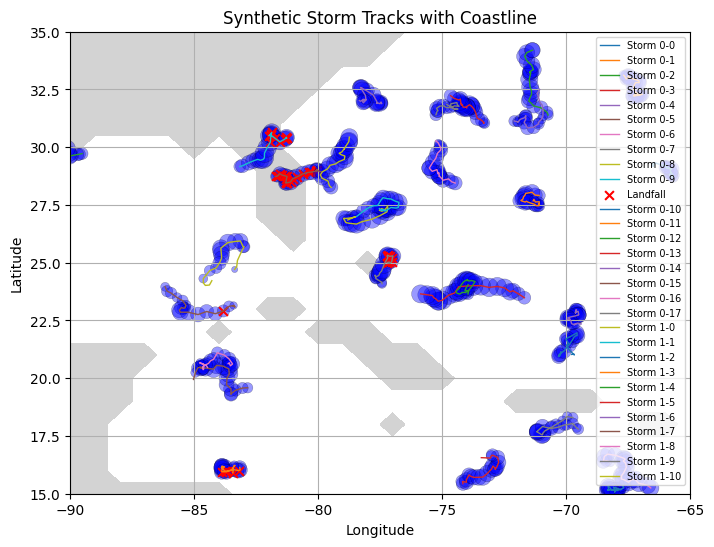

In [23]:
#Call the function!!!

df = run_STORM(years=2)
print(df.head())
plot_tracks(df)

Below We impliement a simulation with Land decay incorportated

In [24]:
def simulate_intensity_with_landfall(track_lat, track_lon, Penv=1010, mpi=880, f_peak=0.4):
    """
    Simulate storm intensity over a track with landfall effects.

    Inputs:
        track_lat, track_lon : arrays of storm track coordinates
        Penv : environmental pressure (hPa)
        mpi : minimum possible pressure (hPa)
        f_peak : fraction of lifetime at which storm reaches peak intensity

    Returns:
        pressure : array of central pressures (hPa)
        wind : array of max winds (m/s)
    """
    # -----------------------
    # Coefficients
    # -----------------------
    b, c, d = 0.3, 1.0, 0.01           # autoregressive / nonlinear
    awind, bwin = 6.7, 0.644           # wind-pressure relationship
    a_int, a_dec = -1.5, 0.8           # asymmetry: intensification vs decay
    t_peak = int(f_peak * len(track_lat))

    # Landfall decay parameters (Kaplan & DeMaria style)
    C1, D1, R, t0, alpha, vb, D0 = 0.0109, -0.0503, 0.9, 150, 0.095, 26.7, 1.0

    # -----------------------
    # Initialize arrays
    # -----------------------
    pressure = [np.random.uniform(1000, Penv)]
    wind = [awind * (Penv - pressure[0])**bwin]
    dp_prev = 0
    on_land = False

    # -----------------------
    # Loop through track
    # -----------------------
    for t, (lat, lon) in enumerate(zip(track_lat[1:], track_lon[1:]), start=1):
        # Check land
        i_flag = int((lat - track_lat[0]) / (track_lat[-1] - track_lat[0]) * (len(track_lat) - 1))
        j_flag = int((lon - track_lon[0]) / (track_lon[-1] - track_lon[0]) * (len(track_lon) - 1))
        # For simplicity we use 0 = ocean, 1 = land
        if not on_land and lon > -60:  # simple land mask from your toy model
            on_land = True
            landfall_index = t
            pres_landfall = pressure[-1]
            v0 = wind[-1] / 0.514444  # convert to kt for Kaplan&DeMaria
            t_land = 3
            j_land = 1

        if not on_land:
            # -----------------------
            # Ocean: autoregressive + asymmetric intensification/decay
            # -----------------------
            a = a_int if t <= t_peak else a_dec
            pres_prev = pressure[-1]
            presmpi = max(pres_prev - mpi, 0)
            dp = a + b*dp_prev + c*np.exp(-d*presmpi) + np.random.normal(0, 2)
            pres_new = max(pres_prev + dp, mpi)
            dp_prev = dp
            pressure.append(pres_new)
            wind.append(awind * (Penv - pres_new)**bwin)

        else:
            # -----------------------
            # Landfall decay (simplified Kaplan&DeMaria)
            # -----------------------
            # distance from landfall
            D = np.sqrt((lat - track_lat[landfall_index])**2 + (lon - track_lon[landfall_index])**2)*111  # rough km
            M = C1*t_land*(t0-t_land)
            b_KM = D1*t_land*(t0-t_land)
            C_KM = M*np.log(D/D0) + b_KM if D>0 else 0
            v = vb + (R*v0 - vb)*np.exp(-alpha*t_land) - C_KM  # kt
            pres_landfall = Penv - (v/awind)**(1/bwin)          # convert back to hPa
            pressure.append(pres_landfall)
            wind.append(v * 0.514444)                            # back to m/s

            t_land += 3  # 3-hourly increments

    return np.array(pressure), np.array(wind)


In [26]:
def plot_tracks(df, basin_bounds=(15, 35, -90, -65)): #def plot_tracks(df, basin_bounds=(5, 25, -80, -40)):
    # --- Land mask for coastline ---
    lats, lons, mask = make_land_mask((basin_bounds[0], basin_bounds[1]),
                                      (basin_bounds[2], basin_bounds[3]))

    plt.figure(figsize=(8, 6))

    # Plot land mask (grey shading for land cells)
    plt.contourf(lons, lats, mask, levels=[0.5, 1.5], colors=["lightgrey"])

    # --- Normalize wind speeds for scaling marker sizes ---
    wind_min, wind_max = df["wind"].min(), df["wind"].max()
    size_min, size_max = 20, 200  # circle size range
    df = df.copy()  # avoid modifying original
    df["wind_size"] = size_min + (df["wind"] - wind_min) / (wind_max - wind_min + 1e-6) * (size_max - size_min)

    # Plot storm tracks
    for (year, storm_id), group in df.groupby(["year", "storm_id"]):
        label = f"Storm {year}-{int(storm_id)}"
        plt.plot(group["lon"], group["lat"], lw=1, label=label)

        # Plot points along the track, size ∝ normalized wind
        plt.scatter(
            group["lon"], group["lat"],
            s=group["wind_size"],
            c="blue", alpha=0.4, edgecolors="k", linewidth=0.3
        )

        # Highlight landfalls
        landfalls = group[group["landfall"] == 1]
        if not landfalls.empty:
            plt.scatter(
                landfalls["lon"], landfalls["lat"],
                c="red", marker="x", s=40, label="Landfall"
            )

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Synthetic Storm Tracks with Coastline")
    plt.xlim(basin_bounds[2], basin_bounds[3])
    plt.ylim(basin_bounds[0], basin_bounds[1])

    # Deduplicate legend entries
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="upper right", fontsize=7)

    plt.grid(True)
    plt.show()

In [27]:
def run_STORM(years=2, basin_bounds =(15, 35, -90, -65)):
    lats, lons, mask = make_land_mask((basin_bounds[0], basin_bounds[1]),
                                      (basin_bounds[2], basin_bounds[3]))
    records = []

    for year in range(years):
        n_storms = sample_storms_per_year()
        genesis_points = sample_genesis_locations(n_storms, basin_bounds, lats, lons, mask)

        for sid, (lat, lon) in enumerate(genesis_points):
            # Simulate track as before
            track_lat, track_lon = simulate_track(lat, lon)

            # Simulate intensity including landfall decay
            pressure, wind = simulate_intensity_with_landfall(track_lat, track_lon, Penv=1010, mpi=880, f_peak=0.4)

            # Check landfall along the track (optional, for flagging)
            landfall_flags = check_landfall(track_lat, track_lon, lats, lons, mask, basin_bounds)

            for t in range(len(track_lat)):
                records.append({
                    "year": year,
                    "storm_id": sid,
                    "time_step": t,
                    "lat": track_lat[t],
                    "lon": track_lon[t],
                    "pressure": pressure[t],
                    "wind": wind[t],
                    "landfall": landfall_flags[t]
                })

    return pd.DataFrame(records)


/tmp/ipython-input-1519056441.py:61: RuntimeWarning: invalid value encountered in scalar power
  wind.append(awind * (Penv - pres_new)**bwin)


   year  storm_id  time_step        lat        lon     pressure       wind  \
0     0         0          0  27.222475 -66.785326  1002.022093  25.520624   
1     0         0          1  27.299655 -66.880744   995.891529  36.841720   
2     0         0          2  27.341764 -66.995470   993.760575  40.335023   
3     0         0          3  27.495437 -67.048829   993.791576  40.285418   
4     0         0          4  27.659847 -67.111056   992.022450  43.064682   

   landfall  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0  


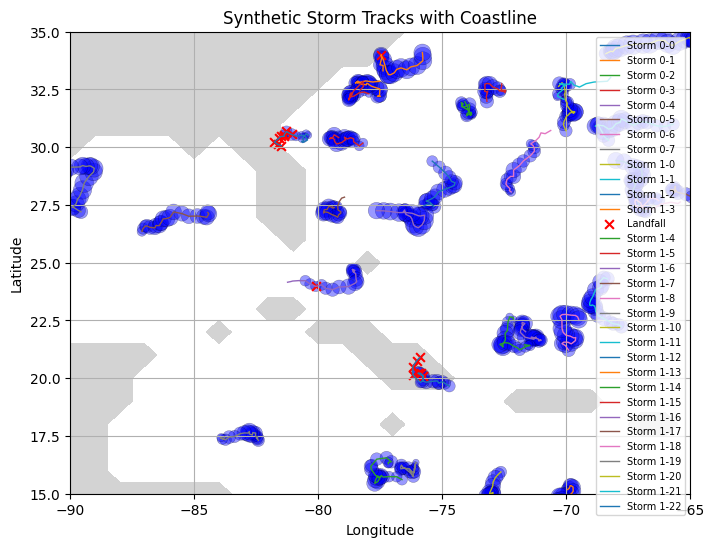

In [31]:
basin_bounds= (15, 35, -90, -65)
df = run_STORM(years=2, basin_bounds=basin_bounds )
print(df.head())
plot_tracks(df, basin_bounds=basin_bounds)